In [1]:
%matplotlib inline


# Optical flow

This tutorial offers a short overview of the optical flow routines available in 
pysteps and it will cover how to compute and plot the motion field from a 
sequence of radar images.


In [2]:
from datetime import datetime
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

from pysteps import io, motion, rcparams
from pysteps.utils import conversion, transformation
from pysteps.visualization import plot_precip_field, quiver

Pysteps configuration file found at: /home/runner/.pysteps/pystepsrc



## Read the radar input images

First, we will import the sequence of radar composites.
You need the pysteps-data archive downloaded and the pystepsrc file
configured with the data_source paths pointing to data folders.



In [3]:
# Selected case
date = datetime.strptime("201505151630", "%Y%m%d%H%M")
data_source = rcparams.data_sources["mch"]

### Load the data from the archive



In [4]:
root_path = data_source["root_path"]
path_fmt = data_source["path_fmt"]
fn_pattern = data_source["fn_pattern"]
fn_ext = data_source["fn_ext"]
importer_name = data_source["importer"]
importer_kwargs = data_source["importer_kwargs"]
timestep = data_source["timestep"]

# Find the input files from the archive
fns = io.archive.find_by_date(
    date, root_path, path_fmt, fn_pattern, fn_ext, timestep=5, num_prev_files=9
)

# Read the radar composites
importer = io.get_method(importer_name, "importer")
R, quality, metadata = io.read_timeseries(fns, importer, **importer_kwargs)

del quality  # Not used

### Preprocess the data



In [5]:
# Convert to mm/h
R, metadata = conversion.to_rainrate(R, metadata)

# Store the reference frame
R_ = R[-1, :, :].copy()

# Log-transform the data [dBR]
R, metadata = transformation.dB_transform(R, metadata, threshold=0.1, zerovalue=-15.0)

# Nicely print the metadata
pprint(metadata)

{'accutime': 5,
 'cartesian_unit': 'm',
 'institution': 'MeteoSwiss',
 'product': 'AQC',
 'projection': '+proj=somerc  +lon_0=7.43958333333333 +lat_0=46.9524055555556 '
               '+k_0=1 +x_0=600000 +y_0=200000 +ellps=bessel '
               '+towgs84=674.374,15.056,405.346,0,0,0,0 +units=m +no_defs',
 'threshold': -10.0,
 'timestamps': array([datetime.datetime(2015, 5, 15, 15, 45),
       datetime.datetime(2015, 5, 15, 15, 50),
       datetime.datetime(2015, 5, 15, 15, 55),
       datetime.datetime(2015, 5, 15, 16, 0),
       datetime.datetime(2015, 5, 15, 16, 5),
       datetime.datetime(2015, 5, 15, 16, 10),
       datetime.datetime(2015, 5, 15, 16, 15),
       datetime.datetime(2015, 5, 15, 16, 20),
       datetime.datetime(2015, 5, 15, 16, 25),
       datetime.datetime(2015, 5, 15, 16, 30)], dtype=object),
 'transform': 'dB',
 'unit': 'mm/h',
 'x1': 255000.0,
 'x2': 965000.0,
 'xpixelsize': 1000.0,
 'y1': -160000.0,
 'y2': 480000.0,
 'yorigin': 'upper',
 'ypixelsize': 1000.0,

## Lucas-Kanade (LK)

The Lucas-Kanade optical flow method implemented in pysteps is a local
tracking approach that relies on the OpenCV package.
Local features are tracked in a sequence of two or more radar images. The
scheme includes a final interpolation step in order to produce a smooth
field of motion vectors.



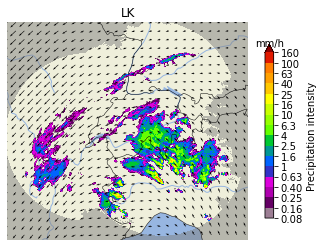

In [6]:
oflow_method = motion.get_method("LK")
V1 = oflow_method(R[-3:, :, :])

# Plot the motion field on top of the reference frame
plot_precip_field(R_, geodata=metadata, title="LK")
quiver(V1, geodata=metadata, step=25)
plt.show()

## Variational echo tracking (VET)

This module implements the VET algorithm presented
by Laroche and Zawadzki (1995) and used in the McGill Algorithm for
Prediction by Lagrangian Extrapolation (MAPLE) described in
Germann and Zawadzki (2002).
The approach essentially consists of a global optimization routine that seeks
at minimizing a cost function between the displaced and the reference image.



Running VET algorithm
original image shape: (3, 640, 710)
padded image shape: (3, 640, 710)
padded template_image image shape: (3, 640, 710)

Number of sectors: 2,2
Sector Shape: (320, 355)
Minimizing

residuals 3102581.058171551
smoothness_penalty 0.0
original image shape: (3, 640, 710)
padded image shape: (3, 640, 712)
padded template_image image shape: (3, 640, 712)

Number of sectors: 4,4
Sector Shape: (160, 178)
Minimizing

residuals 2507515.978176187
smoothness_penalty 0.4972321040151195
original image shape: (3, 640, 710)
padded image shape: (3, 640, 720)
padded template_image image shape: (3, 640, 720)

Number of sectors: 16,16
Sector Shape: (40, 45)
Minimizing

residuals 2261599.3328208188
smoothness_penalty 40.0274102790147
original image shape: (3, 640, 710)
padded image shape: (3, 640, 736)
padded template_image image shape: (3, 640, 736)

Number of sectors: 32,32
Sector Shape: (20, 23)
Minimizing

residuals 2283873.2019218802
smoothness_penalty 186.8423811170226


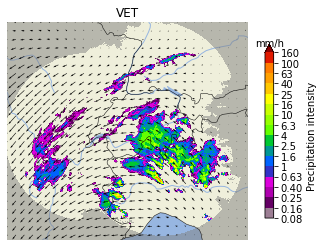

In [7]:
oflow_method = motion.get_method("VET")
V2 = oflow_method(R[-3:, :, :])

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="VET")
quiver(V2, geodata=metadata, step=25)
plt.show()

## Dynamic and adaptive radar tracking of storms (DARTS)

DARTS uses a spectral approach to optical flow that is based on the discrete
Fourier transform (DFT) of a temporal sequence of radar fields.
The level of truncation of the DFT coefficients controls the degree of
smoothness of the estimated motion field, allowing for an efficient
motion estimation. DARTS requires a longer sequence of radar fields for
estimating the motion, here we are going to use all the available 10 fields.



Computing the motion field with the DARTS method.
-----
DARTS
-----
  Computing the FFT of the reflectivity fields...Done in 0.28 seconds.
  Constructing the y-vector...Done in 0.30 seconds.
  Constructing the H-matrix...Done in 1.24 seconds.
  Solving the linear systems...Done in 0.10 seconds.
--- 1.9654359817504883 seconds ---


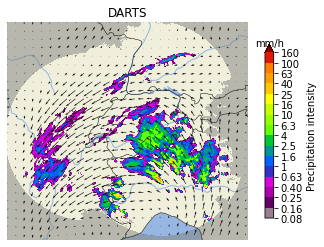

In [8]:
oflow_method = motion.get_method("DARTS")
R[~np.isfinite(R)] = metadata["zerovalue"]
V3 = oflow_method(R)  # needs longer training sequence

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="DARTS")
quiver(V3, geodata=metadata, step=25)
plt.show()

## Anisotropic diffusion method (Proesmans et al 1994)

This module implements the anisotropic diffusion method presented in Proesmans
et al. (1994), a robust optical flow technique which employs the notion of
inconsitency during the solution of the optical flow equations.



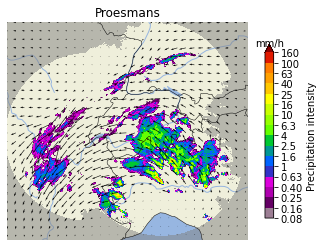

In [9]:
oflow_method = motion.get_method("proesmans")
R[~np.isfinite(R)] = metadata["zerovalue"]
V4 = oflow_method(R[-2:, :, :])

# Plot the motion field
plot_precip_field(R_, geodata=metadata, title="Proesmans")
quiver(V4, geodata=metadata, step=25)
plt.show()

# sphinx_gallery_thumbnail_number = 1